In [6]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report



In [9]:
#import embeddings
fmri_pkl_path = "/Users/aahd/Library/CloudStorage/OneDrive-UniversityofSouthampton/year_4/Deep Learning/cw/DL_MindVideo/fMRI_embeddings.pkl"
img_pkl_path = '/Users/aahd/Library/CloudStorage/OneDrive-UniversityofSouthampton/year_4/Deep Learning/cw/DL_MindVideo/video_embedding.pkl'
text_pkl_path = '/Users/aahd/Library/CloudStorage/OneDrive-UniversityofSouthampton/year_4/Deep Learning/cw/DL_MindVideo/text_embedding.pkl'

In [11]:


with open(fmri_pkl_path, 'rb') as f:
    fmri_embeddings = pickle.load(f)
    
with open(img_pkl_path, 'rb') as f:
    image_embeddings = pickle.load(f)
    
with open(text_pkl_path, 'rb') as f:
    text_embeddings = pickle.load(f)
    
print('fMRI embeddings shape:', fmri_embeddings.shape)
print('Image embeddings shape:', image_embeddings.shape)
print('Text embeddings shape:', text_embeddings.shape)

fMRI embeddings shape: torch.Size([5, 240, 2, 77, 768])
Image embeddings shape: torch.Size([1200, 512])
Text embeddings shape: torch.Size([1200, 512])


In [13]:
fmri_flattened = fmri_embeddings.reshape(1200, -1)  # Shape: [1200, 77 * 768]
pca = PCA(n_components=512)
fmri_reduced = pca.fit_transform(fmri_flattened)  # Shape: [1200, 512]
print(fmri_reduced.shape)

(1200, 512)


In [14]:

image_embeddings_normalized = normalize(image_embeddings, axis=1)
text_embeddings_normalized = normalize(text_embeddings, axis=1)
fmri_embeddings_normalized = normalize(fmri_reduced, axis=1)


In [16]:
print('Image embeddings shape:', image_embeddings_normalized.shape)
print('Text embeddings shape:', text_embeddings_normalized.shape)
print('fMRI embeddings shape:', fmri_embeddings_normalized.shape)

Image embeddings shape: (1200, 512)
Text embeddings shape: (1200, 512)
fMRI embeddings shape: (1200, 512)


Using device: cpu


Training:  11%|█         | 11/100 [00:01<00:11,  7.46it/s]

Epoch [10/100], Train Loss: 2.9761, Train Accuracy: 0.2432, Val Loss: 2.9903, Val Accuracy: 0.0917


Training:  21%|██        | 21/100 [00:03<00:11,  7.09it/s]

Epoch [20/100], Train Loss: 2.9556, Train Accuracy: 0.3417, Val Loss: 2.9851, Val Accuracy: 0.1104


Training:  31%|███       | 31/100 [00:04<00:09,  7.62it/s]

Epoch [30/100], Train Loss: 2.9350, Train Accuracy: 0.3781, Val Loss: 2.9800, Val Accuracy: 0.1167


Training:  41%|████      | 41/100 [00:06<00:07,  7.78it/s]

Epoch [40/100], Train Loss: 2.9147, Train Accuracy: 0.3932, Val Loss: 2.9749, Val Accuracy: 0.1208


Training:  51%|█████     | 51/100 [00:07<00:06,  8.13it/s]

Epoch [50/100], Train Loss: 2.8945, Train Accuracy: 0.3896, Val Loss: 2.9700, Val Accuracy: 0.1250


Training:  61%|██████    | 61/100 [00:08<00:04,  8.18it/s]

Epoch [60/100], Train Loss: 2.8747, Train Accuracy: 0.4078, Val Loss: 2.9652, Val Accuracy: 0.1271


Training:  71%|███████   | 71/100 [00:09<00:03,  8.09it/s]

Epoch [70/100], Train Loss: 2.8557, Train Accuracy: 0.4083, Val Loss: 2.9606, Val Accuracy: 0.1271


Training:  81%|████████  | 81/100 [00:11<00:02,  8.07it/s]

Epoch [80/100], Train Loss: 2.8367, Train Accuracy: 0.4031, Val Loss: 2.9561, Val Accuracy: 0.1292


Training:  91%|█████████ | 91/100 [00:12<00:01,  8.06it/s]

Epoch [90/100], Train Loss: 2.8170, Train Accuracy: 0.4125, Val Loss: 2.9516, Val Accuracy: 0.1312


Training: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch [100/100], Train Loss: 2.7984, Train Accuracy: 0.4146, Val Loss: 2.9472, Val Accuracy: 0.1354
Training complete


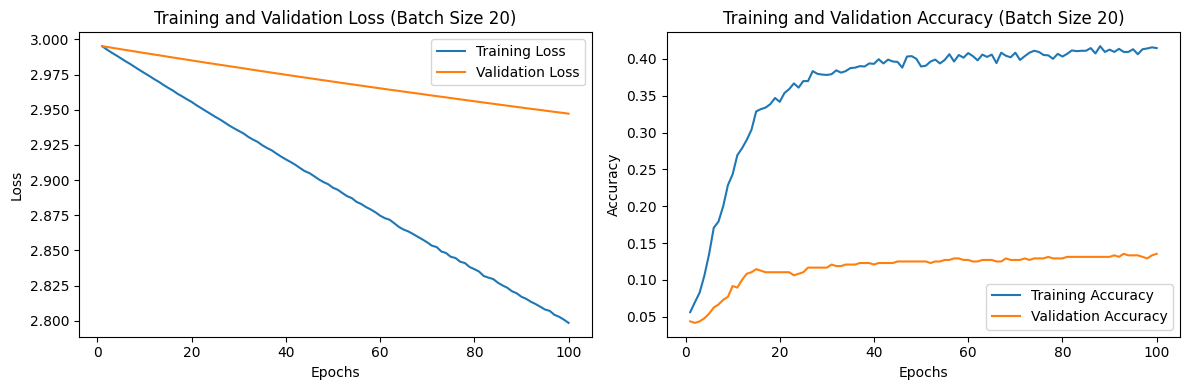

In [20]:

class LinearProjection(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearProjection, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_dataloaders(batch_size, fmri_embeddings_tensor, image_embeddings_tensor, text_embeddings_tensor):
    dataset = TensorDataset(fmri_embeddings_tensor, image_embeddings_tensor, text_embeddings_tensor)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

def calculate_accuracy(similarity, labels):
    pred = torch.argmax(similarity, dim=1)
    correct = (pred == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy, pred.cpu().numpy()

def train_one_epoch(model, criterion, optimizer, train_loader, device):
    model.train()
    train_loss, train_correct = 0.0, 0

    for fmri, image, text in train_loader:
        optimizer.zero_grad()

        fmri, image, text = fmri.to(device), image.to(device), text.to(device)

        # Project fMRI embeddings
        projected_fmri_embeddings = model(fmri)

        # Calculate cosine similarity
        image_similarity = torch.matmul(projected_fmri_embeddings, image.T)
        text_similarity = torch.matmul(projected_fmri_embeddings, text.T)

        # diagonal elements should be the highest similarity
        labels = torch.arange(fmri.size(0)).to(device)

        # loss
        loss_image = criterion(image_similarity, labels)
        loss_text = criterion(text_similarity, labels)
        loss = (loss_image + loss_text) / 2

        # Backprop
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        accuracy_image, _ = calculate_accuracy(image_similarity, labels)
        accuracy_text, _ = calculate_accuracy(text_similarity, labels)
        train_correct += accuracy_image
        train_correct += accuracy_text

    return train_loss / len(train_loader), train_correct / (2 * len(train_loader))

def validate_one_epoch(model, criterion, val_loader, device):
    model.eval()
    val_loss, val_correct = 0.0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for fmri, image, text in val_loader:
            fmri, image, text = fmri.to(device), image.to(device), text.to(device)

            # Project fMRI embeddings
            projected_fmri_embeddings = model(fmri)

            # Calculate cosine similarity
            image_similarity = torch.matmul(projected_fmri_embeddings, image.T)
            text_similarity = torch.matmul(projected_fmri_embeddings, text.T)

            # Create labels (diagonal elements should be the highest similarity)
            labels = torch.arange(fmri.size(0)).to(device)

            # Calculate loss
            loss_image = criterion(image_similarity, labels)
            loss_text = criterion(text_similarity, labels)
            loss = (loss_image + loss_text) / 2

            val_loss += loss.item()
            accuracy_image, preds_image = calculate_accuracy(image_similarity, labels)
            accuracy_text, preds_text = calculate_accuracy(text_similarity, labels)
            val_correct += accuracy_image
            val_correct += accuracy_text

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds_image)  # or preds_text for text similarity

    return val_loss / len(val_loader), val_correct / (2 * len(val_loader)), all_labels, all_preds

def plot_and_save_results(epochs, train_losses, val_losses, train_accuracies, val_accuracies, batch_size):
    results_dir = f'results/batch_size_{batch_size}'
    os.makedirs(results_dir, exist_ok=True)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (Batch Size {batch_size})')
    plt.legend()
    plt.savefig(f'{results_dir}/loss_plot.png')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy (Batch Size {batch_size})')
    plt.legend()
    plt.savefig(f'{results_dir}/accuracy_plot.png')

    plt.tight_layout()
    plt.show()

def save_classification_report(all_labels, all_preds, batch_size):
    results_dir = f'results/batch_size_{batch_size}'
    os.makedirs(results_dir, exist_ok=True)
    
    # Unique classes from all_labels
    unique_classes = np.unique(all_labels)
    target_names = [f'class_{i}' for i in unique_classes]
    
    report = classification_report(all_labels, all_preds, target_names=target_names)
    with open(f'{results_dir}/classification_report.txt', 'w') as f:
        f.write(report)

def run_training(batch_size, num_epochs=100, train_one_loop=False):
    device = get_device()
    print(f"Using device: {device}")

    projection_layer = LinearProjection(512, 512).to(device)
    optimizer = optim.Adam(projection_layer.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    image_embeddings_tensor = torch.tensor(image_embeddings_normalized, dtype=torch.float32).to(device)
    text_embeddings_tensor = torch.tensor(text_embeddings_normalized, dtype=torch.float32).to(device)
    fmri_embeddings_tensor = torch.tensor(fmri_embeddings_normalized, dtype=torch.float32).to(device)

    train_loader, val_loader = create_dataloaders(batch_size, fmri_embeddings_tensor, image_embeddings_tensor, text_embeddings_tensor)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in tqdm(range(num_epochs), desc="Training"):
        train_loss, train_accuracy = train_one_epoch(projection_layer, criterion, optimizer, train_loader, device)
        val_loss, val_accuracy, all_labels, all_preds = validate_one_epoch(projection_layer, criterion, val_loader, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if (epoch + 1) % 10 == 0 or train_one_loop:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
                  f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

        if train_one_loop:
            break

    print("Training complete")

    save_classification_report(all_labels, all_preds, batch_size)

    epochs = range(1, len(train_losses) + 1)
    plot_and_save_results(epochs, train_losses, val_losses, train_accuracies, val_accuracies, batch_size)

batch_sizes = [20]

for batch_size in batch_sizes:
    run_training(batch_size)
